# Flowers Classification


# import Libraries

In [135]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import logging
# Set TensorFlow log level to only display errors
tf.get_logger().setLevel(logging.ERROR)

# Explore Data

In [136]:
path="/kaggle/input/flowers/flowers"
categories=os.listdir(path)
print(categories)

['astilbe', 'daffodil', 'black_eyed_susan', 'bellflower', 'common_daisy', 'coreopsis', 'dandelion', 'water_lily', 'carnation', 'calendula', 'california_poppy', 'sunflower', 'tulip', 'rose', 'magnolia', 'iris']


## Get images paths with labels

load the images path into dataframe

In [7]:
def create_image_dataframe(dataset_dir):
    """
    Creates a DataFrame with image paths and labels from a dataset directory.
    """
    data = []
    
    image_extensions = ['*.png', '*.jpg', '*.jpeg',]
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(dataset_dir, '**', ext), recursive=True))
    
    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        data.append((label, path))
    
    df = pd.DataFrame(data, columns=['label', 'path'])
    return df

In [9]:
df=create_image_dataframe(path)
df.head()

,label,path
0,astilbe,/kaggle/input/flowers/flowers/astilbe/11875142...
1,astilbe,/kaggle/input/flowers/flowers/astilbe/58795386...
2,astilbe,/kaggle/input/flowers/flowers/astilbe/39405092...
3,astilbe,/kaggle/input/flowers/flowers/astilbe/27763628...
4,astilbe,/kaggle/input/flowers/flowers/astilbe/67323836...


# show some images

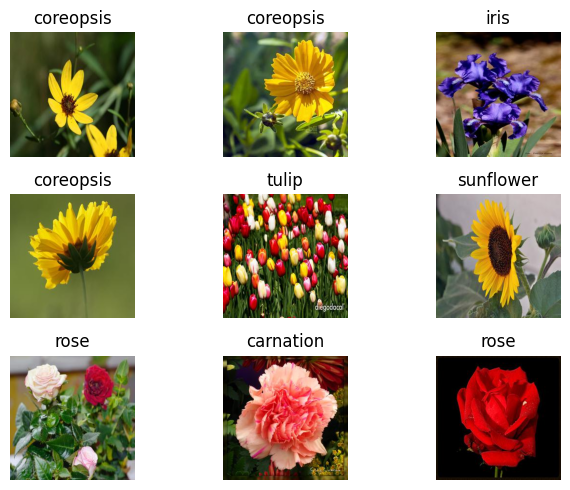

In [31]:
num_images=9
# Randomly sample num_images from the DataFrame
sampled_df = df.sample(n=num_images).reset_index(drop=True)

plt.figure(figsize=(7, 5))

for i in range(num_images):
    plt.subplot(3, 3, i + 1)

    # Read the image
    img_path = sampled_df.iloc[i]['path']
    img = plt.imread(img_path)

    plt.imshow(img)
    plt.title(sampled_df.iloc[i]['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

## labels counts

In [32]:
counts=df['label'].value_counts()
counts

label
iris                1054
dandelion           1052
tulip               1048
magnolia            1048
coreopsis           1047
sunflower           1027
california_poppy    1022
black_eyed_susan    1000
rose                 999
water_lily           982
common_daisy         980
calendula            978
daffodil             970
carnation            923
bellflower           873
astilbe              737
Name: count, dtype: int64

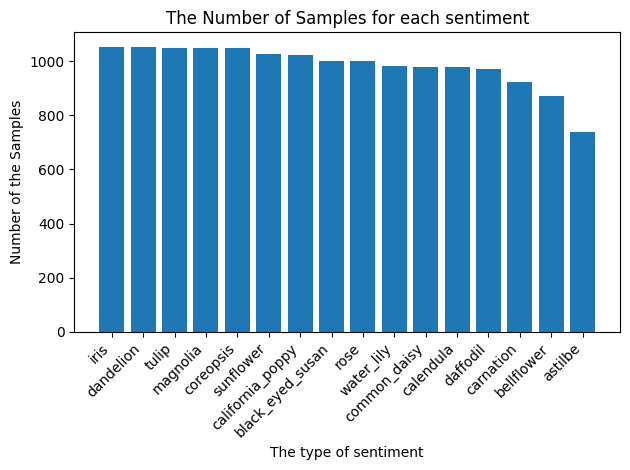

In [33]:
unique_labels=['iris', 'dandelion', 'tulip', 'magnolia', 'coreopsis', 'sunflower', 
 'california_poppy', 'black_eyed_susan', 'rose', 'water_lily', 'common_daisy', 
 'calendula', 'daffodil', 'carnation', 'bellflower', 'astilbe']
plt.bar(unique_labels, counts, width=0.8)  

plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of Samples for each sentiment")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

## Selcet classes 


### we will work with only 4 classes
- common_daisy
- bellflower
- rose
- sunflower

In [37]:
selected_labels=['common_daisy', 'bellflower', 'rose', 'sunflower']
import pandas as pd

def select_and_sample_classes(df, selected_labels, num_samples=700):

    # Filter the DataFrame for selected labels
    filtered_df = df[df['label'].isin(selected_labels)]
    
    sampled_df = pd.DataFrame()
    for label in selected_labels:
        label_df = filtered_df[filtered_df['label'] == label].sample(n=num_samples, replace=True)
        sampled_df = pd.concat([sampled_df, label_df], ignore_index=True)
    
    return sampled_df

sampled_df = select_and_sample_classes(df, selected_labels, num_samples=700)
sampled_df['label'].value_counts() 


label
common_daisy    700
bellflower      700
rose            700
sunflower       700
Name: count, dtype: int64

# Split The Data 

In [137]:
# Splitting data into training (70%), testing (15%), and validation (15%) sets
train_df, temp_df = train_test_split(sampled_df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Testing set shapes:", test_df.shape)
print("Validation set shapes:", valid_df.shape)

Training set shapes: (1960, 2)
Testing set shapes: (420, 2)
Validation set shapes: (420, 2)


# Data Generattors

In [138]:
train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
#     shear_range=0.2,
#     rotation_range=.1,
#     zoom_range=0.2,       
#     horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', 
    y_col='label',   
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical', 
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path', 
    y_col='label',
    target_size=(224, 224), 
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False  
)

# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path', 
    y_col='label',  
    target_size=(224, 224),  
    color_mode='rgb',
    batch_size=64,  
    class_mode='categorical',
    shuffle=False  
)

Found 1960 validated image filenames belonging to 4 classes.
Found 420 validated image filenames belonging to 4 classes.
Found 420 validated image filenames belonging to 4 classes.


In [44]:
classes=list(train_generator.class_indices)
classes

['bellflower', 'common_daisy', 'rose', 'sunflower']

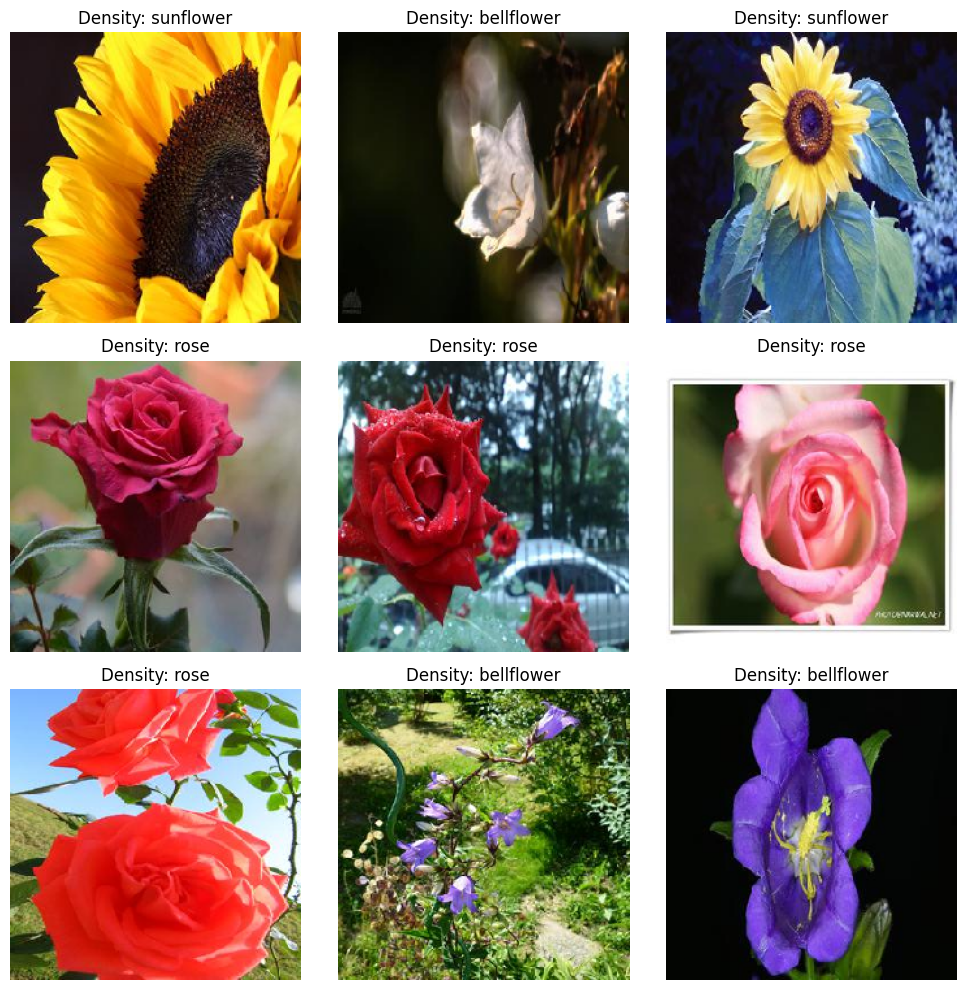

In [45]:
batch_size = 9
# Generate a batch of images and labels
images, labels = next(train_generator)
# Plot the images with their labels
plt.figure(figsize=(10, 10))
for i in range(min(len(images), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = np.argmax(labels[i])
    plt.title(f"Density: {classes[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# shapes of data

In [32]:
print(f'x_train shape :         {x_train.shape}')
print(f'y_train shape :         {y_train.shape}\n')

print(f'x_validation shape :    {x_valid.shape}')
print(f'y_validation shape :    {y_valid.shape}\n')

print(f'x_test shape :          {x_test.shape}')
print(f'x_test shape :          {y_test.shape}')


x_train shape :         (2756, 224, 224, 3)
y_train shape :         (2756, 4)

x_validation shape :    (307, 224, 224, 3)
y_validation shape :    (307, 4)

x_test shape :          (341, 224, 224, 3)
x_test shape :          (341, 4)


## CNN Model

In [115]:
model=keras.models.Sequential()

model.add(Conv2D(64,(3,3),input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))


model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(4,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │    95,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,595,076 (364.67 MB)

 Trainable params: 95,593,924 (364.66 MB)

 Non-trainable params: 1,152 (4.50 KB)

## save best weight

In [117]:
weight_path = "cnn_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

## Train the model

In [118]:
epoch_num=20
history=model.fit(train_generator,epochs=epoch_num,validation_data=(valid_generator),callbacks=callbacks_list)

Epoch 1/20
15/62 ━━━━━━━━━━━━━━━━━━━━ 18s 384ms/step - accuracy: 0.5438 - loss: 2.3597

W0000 00:00:1717205999.662903     901 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6441 - loss: 1.6028
Epoch 1: val_accuracy improved from -inf to 0.53571, saving model to cnn_weights.best.weights.h5


W0000 00:00:1717206003.885690     899 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.6451 - loss: 1.5945 - val_accuracy: 0.5357 - val_loss: 1.0206
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8290 - loss: 0.4557
Epoch 2: val_accuracy did not improve from 0.53571
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8291 - loss: 0.4556 - val_accuracy: 0.4929 - val_loss: 1.0600
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8609 - loss: 0.4107
Epoch 3: val_accuracy improved from 0.53571 to 0.65476, saving model to cnn_weights.best.weights.h5
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.8612 - loss: 0.4100 - val_accuracy: 0.6548 - val_loss: 0.8151
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9129 - loss: 0.2574
Epoch 4: val_accuracy did not improve from 0.65476
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9129 - loss: 0.2577 - val_accuracy: 0.6167 - val_loss: 0.8221
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9057 - loss

In [119]:
# load the best weights
model.load_weights(weight_path)

In [120]:
# Evaluate the model on the test data
evaluation_result = model.evaluate(test_generator)

# The result
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9370 - loss: 0.2745
Test Loss: 0.36282747983932495
Test Accuracy: 0.9214285612106323


# Confusion Matrix

In [121]:
#  predictions on test data
y_pred = model.predict(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


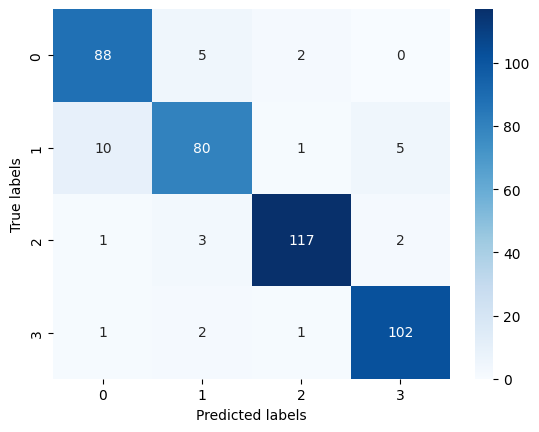

In [122]:
y_pred_classes = np.argmax(y_pred, axis=1)
#  y_test is one-hot encoded
y_test_classes = test_generator.classes


confusion_Matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the confusion matrix as a heatmap
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# graph between the training and validation accuracy and loss

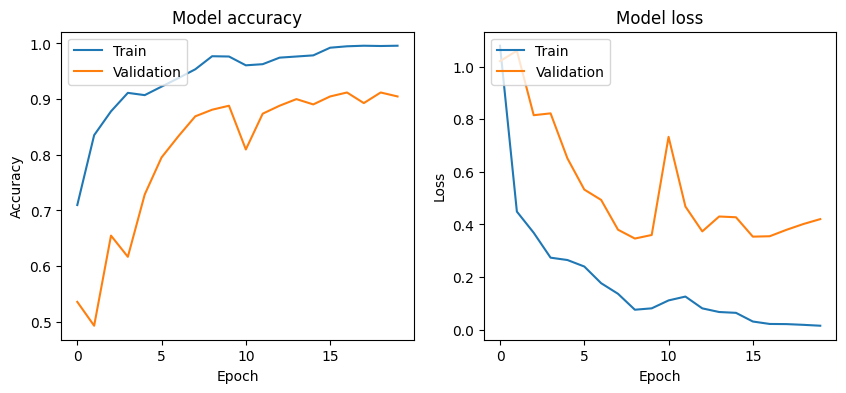

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Plot the training and validation accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the training and validation loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()

# Classification Report

In [124]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        95
           1       0.89      0.83      0.86        96
           2       0.97      0.95      0.96       123
           3       0.94      0.96      0.95       106

    accuracy                           0.92       420
   macro avg       0.92      0.92      0.92       420
weighted avg       0.92      0.92      0.92       420



# Test the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


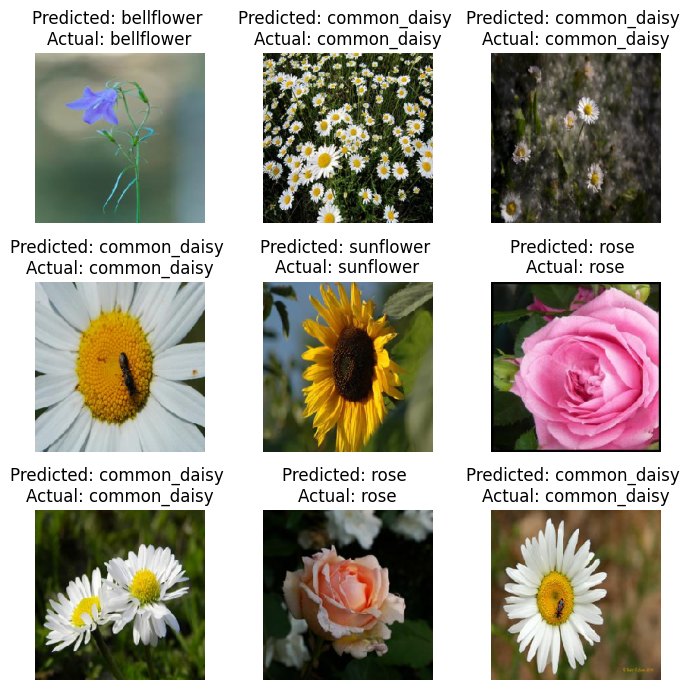

In [132]:
x_test,y_test=next(test_generator)
# make a figure that images will be shown in
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()

for i in range(9):
    #predict image
    predicted = model.predict(np.array([x_test[i]]))
    # take larger value which is predicted class
    predictedClass = np.argmax(predicted)
    actual = np.argmax(y_test[i])
    # plot actual class and predicted with the image
    axs[i].imshow(x_test[i], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()